``Start modelling on metadata again. No imgs only metadata.``

```find correlation with lb and reach 0.75s```


# Load data and dependencies

In [323]:
import warnings
import sys
import os
import time
import joblib
import random
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from joblib import Parallel, delayed

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

warnings.filterwarnings('ignore')

In [5]:
metadata = pd.read_csv('../data/metadata.csv')
sub_format = pd.read_csv('../data/submission_format.csv')
train_labels = pd.read_csv('../data/train_labels.csv')

# Utils

In [96]:
def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

In [7]:
def dens_to_sev(x: float)-> int:
    """takes in density value in cells/ml and returns severity category"""
    if (x < 20_000) : return 1
    elif (x >= 20_000) and (x < 100_000) : return 2
    elif (x >= 100_000) and (x < 1_000_000) : return 3
    elif (x >= 1_000_000) and (x < 10_000_000) : return 4
    elif x > 10_000_000 : return 5

In [331]:
#  Utils
def get_data_by_date( date=None, data=None):
    return data[data.date == date]


def get_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

def analyize_matches(y_true, y_pred, plot=False):
    print("Exact matches: ", sum(y_true == y_pred) / len(y_true))
    print("Missed by 1: ", sum(abs(y_true - y_pred) == 1) / len(y_true))
    print("Missed by 2: ", sum(abs(y_true - y_pred) == 2) / len(y_true))
    print("Missed by 3: ", sum(abs(y_true - y_pred) == 3) / len(y_true))
    print("Missed by 4: ", sum(abs(y_true - y_pred) == 4) / len(y_true))
    
    stupid_vals = []
    for i in range(1, 6):
        stupid_vals.append(
            ((sum([1 for x, y in zip(y_true, y_pred) if x == i and y == i])/len(y_true))*100, (sum(y_true == i)/len(y_true))*100)
            )

    print()
    for i in range(5):
        print(f"Severity {i+1} : accuracy: {stupid_vals[i][0]}% - prevalence: {stupid_vals[i][1]}%")

    print()
    print("Classification report:")
    print(classification_report(y_true, y_pred))
    
    if plot:
        print()
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Reds')

# Add date fts

In [8]:
metadata.date = pd.to_datetime(metadata.date)
metadata['year'] = metadata.date.dt.year
metadata['month'] = metadata.date.dt.month
metadata['week'] = metadata.date.dt.isocalendar().week

seasons = {
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10: 4,
    11: 4,
    12: 1
}

reg_sev_map = {
    'midwest': 2,
    'northeast': 2,
    'south' : 2,
    'west' : 4
}

metadata['season'] = metadata.month.map(seasons)

region = pd.concat((train_labels, sub_format[['region', 'uid']]), axis=0)

data = pd.merge(metadata, region, on='uid', how='left')
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,1.0,585.0
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,1.0,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,1.0,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,3.0,111825.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,2.0,48510.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,1.0,1271.0
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,1.0,9682.0


# Split

In [9]:
test_data = data[data.split == 'test']
test_data.shape, data.shape

((6510, 12), (23570, 12))

In [10]:
train_data = data[data.split == 'train']
train_data.shape, data.shape

((17060, 12), (23570, 12))

In [11]:
tr_data, val_data = train_test_split(train_data, test_size=0.15, random_state=123456789, shuffle=True)
tr_data.shape, val_data.shape

((14501, 12), (2559, 12))

In [12]:
# split data similar to test data
val_data['date_reg'] = val_data.date.astype(str) + "_" +  val_data.region
tr_data['date_reg'] = tr_data.date.astype(str) + "_" +  tr_data.region

assert (val_data.columns == tr_data.columns).all()

print(set(val_data.uid).intersection(set(tr_data.uid)))

# percentage of intersection date and regs before
print(f" % of intersection between date and regions in val and train sets before correction: {len(set(val_data.date_reg).intersection(set(tr_data.date_reg)))/val_data.date_reg.nunique()}")

datereg_to_remove = val_data.date_reg.sample(frac=0.40, random_state=123456789)
tr_data2_te_dist = tr_data[~tr_data.date_reg.isin(datereg_to_remove)]
val_data2_te_dist = val_data

print(f" % of intersection between date and regions in val and train sets after correction: {len(set(val_data2_te_dist.date_reg).intersection(set(tr_data2_te_dist.date_reg)))/val_data2_te_dist.date_reg.nunique()}")


print(f" % of intersection between dates in val and train sets: {len(set(val_data2_te_dist.date).intersection(set(tr_data2_te_dist.date)))/val_data2_te_dist.date.nunique() :<75f} ")
print(f" % of intersection between date in test and train sets: {len(set(test_data.date).intersection(set(train_data.date)))/test_data.date.nunique():<75f}" )

tr_data2_te_dist.shape, val_data2_te_dist.shape, train_data.shape, val_data.shape

set()
 % of intersection between date and regions in val and train sets before correction: 0.9328793774319066
 % of intersection between date and regions in val and train sets after correction: 0.36867704280155644
 % of intersection between dates in val and train sets: 0.656211                                                                    
 % of intersection between date in test and train sets: 0.701095                                                                   


((5617, 13), (2559, 13), (17060, 12), (2559, 13))

In [13]:
tr_data3 = tr_data.copy()
val_data3 = val_data.copy()

datereg_to_remove = tr_data3.date_reg.sample(frac=0.60, random_state=123456789)
val_data3_te_dist = val_data3[~val_data3.date_reg.isin(datereg_to_remove)]
tr_data3_te_dist = tr_data3

print("matching dateregs btw val and tr:", len(set(val_data3_te_dist.date_reg).intersection(set(tr_data3_te_dist.date_reg)))/val_data3_te_dist.date_reg.nunique())
print("matching dates btw val and tr:",len(set(val_data3_te_dist.date).intersection(set(tr_data3_te_dist.date)))/val_data3_te_dist.date.nunique())

tr_data3_te_dist.shape, val_data3_te_dist.shape

matching dateregs btw val and tr: 0.4
matching dates btw val and tr: 0.7589285714285714


((14501, 13), (131, 13))

In [14]:
#  split by time
train_data = train_data.sort_values(by='date')
train_data_ts = train_data[train_data.date < '2019-01-01']
val_data_ts = train_data[train_data.date >= '2019-01-01']

train_data_ts.shape, val_data_ts.shape

((11968, 12), (5092, 12))

In [15]:
tr_data.sort_values(by='date', inplace=True)
val_data.sort_values(by='date', inplace=True)

In [141]:
test_data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
12,aair,33.042600,-117.076000,2014-11-01,test,2014,11,44,4,west,NaN,NaN
14,aajw,40.703968,-80.293050,2015-08-26,test,2015,8,35,3,northeast,NaN,NaN
15,aalr,38.972500,-94.672930,2019-08-26,test,2019,8,35,3,midwest,NaN,NaN
16,aalw,34.279000,-118.905000,2018-01-08,test,2018,1,2,1,west,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23556,zzpn,40.136410,-80.473740,2019-07-08,test,2019,7,28,3,northeast,NaN,NaN
23560,zzrv,36.875400,-121.561000,2019-09-17,test,2019,9,38,4,west,NaN,NaN
23563,zzsx,34.210000,-78.929389,2019-07-16,test,2019,7,29,3,south,NaN,NaN
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN


In [145]:
X_test = test_data[train_data.columns]
X_test

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
12,aair,33.042600,-117.076000,2014-11-01,test,2014,11,44,4,west,NaN,NaN
14,aajw,40.703968,-80.293050,2015-08-26,test,2015,8,35,3,northeast,NaN,NaN
15,aalr,38.972500,-94.672930,2019-08-26,test,2019,8,35,3,midwest,NaN,NaN
16,aalw,34.279000,-118.905000,2018-01-08,test,2018,1,2,1,west,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23556,zzpn,40.136410,-80.473740,2019-07-08,test,2019,7,28,3,northeast,NaN,NaN
23560,zzrv,36.875400,-121.561000,2019-09-17,test,2019,9,38,4,west,NaN,NaN
23563,zzsx,34.210000,-78.929389,2019-07-16,test,2019,7,29,3,south,NaN,NaN
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN


# Modelling

## CV

In [247]:
def train_eval(model, X_train=None, X_val=None, y_train=None, y_val=None, X_test=None, y_test=None):
    """
    train and eval util func,
    returns trained model, soft_preds, and tr, val, test rmses
    REMEMBER returns soft-preds
    """
    
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    val_rmse = rmse(y_val, np.clip(np.round(val_preds), 1, 5))
    train_rmse = rmse(y_train, np.clip(np.round(model.predict(X_train)), 1, 5))   # don't forget to clip!
    print("Train RMSE: ", train_rmse)
    print("Val RMSE:", val_rmse)
    if X_test is not None and y_test is not None:
        test_rmse = mse(y_test, np.clip(np.round(model.predict(X_test)), 1, 5), squared=False)
        print('TEST RMSE: ', test_rmse)
    else:
        test_rmse = 0
        
    # print("TEST RMSE:", mse(y_val, np.round(model.predict(X_val)), squared=False))
    return model, val_preds, train_rmse, val_rmse, test_rmse


def cv_it(model, X_train=None, y_train=None, X_test=None, y_test=None, splits=10, cv_predict=False):
    """ cv in stratified kfold fashion, 
    returns train, val, test rmses, and cv preds for test and train if cv_predict=True
    remember to round preds"""
    
    skf = StratifiedKFold(n_splits=splits, random_state=12_000, shuffle=True)
    # tscv = TimeSeriesSplit(n_splits=splits, test_size=200)
    print('Using cols: ', X_train.columns.values)

    train_rmses = []
    val_rmses = []
    test_rmses = []
    
    if cv_predict:
        cvpreds_test = np.zeros(shape=(len(X_test), splits))
        cvpreds_train = np.zeros(shape=(len(X_train)))

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):

        print(f'-----------------------Fold-{fold}-------------------------')
        X_train_subset, y_train_subset = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_subset, y_val_subset = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        print(f'Training on {X_train_subset.shape[0]} samples' )
        print(f'Validating on {X_val_subset.shape[0]} samples' )

        model, val_preds, train_rmse, val_rmse, test_rmse= train_eval(
                                    model=model, 
                                    X_train=X_train_subset, 
                                    y_train=y_train_subset, 
                                    X_val=X_val_subset, 
                                    y_val=y_val_subset,
                                    X_test=X_test,
                                    y_test=y_test
                                    )

        sns.barplot(model.feature_importances_, model.feature_names_in_)

        val_rmses.append(val_rmse)
        train_rmses.append(train_rmse)
        
        if cv_predict:
            test_rmses.append(test_rmse)
            # save predictions for ensembling
            if X_test is not None:
                cvpreds_test[:, fold] = model.predict(X_test)
            cvpreds_train[val_idx] = val_preds
                    
    print()
    print("Mean Train RMSE:", np.mean(train_rmses), "std:", np.std(train_rmses))
    print("Mean Val RMSE:", np.mean(val_rmses), "std:", np.std(val_rmses))
    print("Mean Test RMSE:", np.mean(test_rmses), "std:", np.std(test_rmses))

    
    if cv_predict:
        return cvpreds_test, cvpreds_train

## KNN

In [54]:
def knn(row=None, train_data=tr_data, k=1):
    """
    row : pd.Series (row from val_data)
    train_data : pd.DataFrame (all_data)
    k : int number of nearest neighbours to consider
    
    algo:
    1. Get past month data collected till the current row
    2. Get the k nearest neighbours (geodesic dist using lat, lng) from the above data
    3. Get the mean of the severity from the above rows
    4. Return the mean of the nearest neighbours severity

    """
    
    if row is None:
        print('Row None bruv!')
        return None
    
    uid = row.uid
    date = row.date
    region = row.region
    past_date = date - pd.Timedelta(days=30)
    
    past_month_data = train_data[(train_data.date < date) & (train_data.date >= past_date)]
    past_month_data.sort_values(by='date', inplace=True)
    
    # if no past data, return the mean of the region
    if len(past_month_data) == 0:
        return reg_sev_map[region]
        
    dist_matrix =pd.DataFrame(columns=['uid', 'dist'])       # 0th col for uid, 1st col for dist
    for i, past_row in enumerate(past_month_data.itertuples()):
        dist_matrix.loc[i, 'uid'] = past_row.uid
        dist_matrix.loc[i, 'dist'] = get_distance(row.latitude, row.longitude, past_row.latitude, past_row.longitude)   # returns geodesic dist in km

    # get mean of top k nearest neighbours
    n_uids = dist_matrix.sort_values(by='dist').head(k).uid.values
    nn_severity = train_data[train_data.uid.isin(n_uids)].severity.mean()
    
    return np.round(nn_severity)


## Xgb

In [118]:
tr_data.columns

Index(['uid', 'latitude', 'longitude', 'date', 'split', 'year', 'month',
       'week', 'season', 'region', 'severity', 'density', 'date_reg'],
      dtype='object')

In [119]:
drop_cols = ['date','uid', 'severity', 'split', 'density', 'date_reg']

In [183]:
xgb = XGBRegressor(n_estimators=1000, n_jobs=-1, random_state=12_000, gpu_id=0, tree_method='gpu_hist')

X_train = tr_data.drop(columns=drop_cols)
X_train.week = X_train.week.astype('int')
X_train.region = X_train.region.map(reg_sev_map)
y_train = tr_data.severity

X_val = val_data.drop(columns=drop_cols)
X_val.week = X_val.week.astype('int')
X_val.region = X_val.region.map(reg_sev_map)
y_val = val_data.severity

model, _, *rmses = train_eval(model=xgb, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

Train RMSE:  0.4753781808917403
Val RMSE: 0.7314195782537621


Text(0.5, 1.0, 'naive')

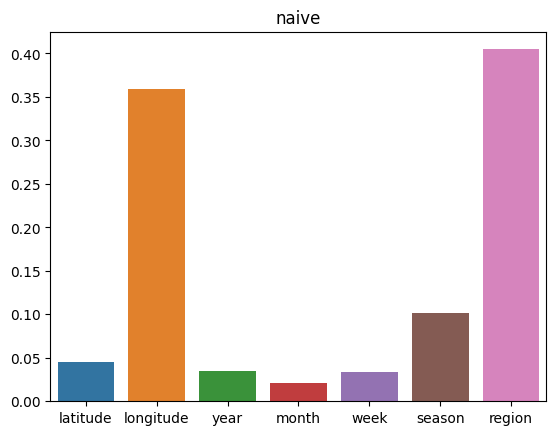

In [184]:
# plot feature importance
sns.barplot(model.feature_names_in_, model.feature_importances_)
plt.title('naive')

In [185]:
#  treees are soo fucking unstable...
# probabaly tuning and ensembling will help and add. fts

# Mean Val RMSE: 0.7475977455132723 std: 0.020832714115182446


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, predictor=None, random_state=12000,
             reg_alpha=None, reg_lambda=None, ...)
Using cols:  ['latitude' 'longitude' 'year' 'month' 'week' 'season' 'region']
-----------------------Fold-0-------------------------
Training on 13050 samples
Validating on 1451 samples
Train RMSE:  0.5496080107833595
Val RMSE: 0.7227712957556476
-----------------------Fold-1-

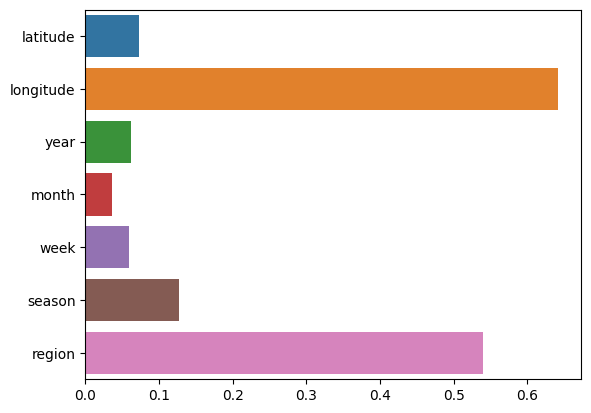

In [186]:
xgb = XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
print(xgb)

cv_it(model=xgb, X_train=X_train, y_train=y_train, X_test=None, y_test=None, splits=10, cv_predict=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, predictor=None, random_state=12,
             reg_alpha=None, reg_lambda=None, ...)
Using cols:  ['latitude' 'longitude' 'year' 'month' 'week' 'season' 'region']
-----------------------Fold-0-------------------------
Training on 13050 samples
Validating on 1451 samples
Train RMSE:  0.6386647949484248
Val RMSE: 0.7122052995432216
-----------------------Fold-1----

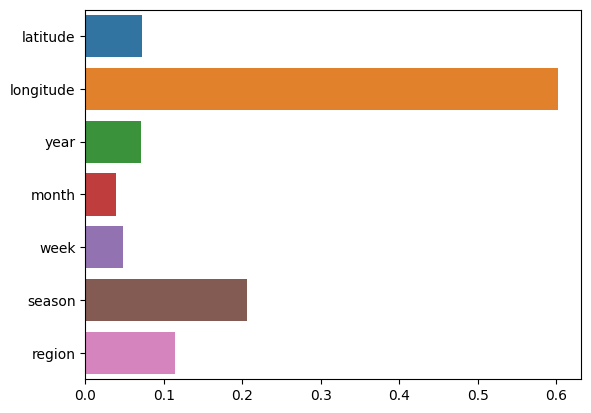

In [187]:
xgb = XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.1, n_jobs=-1, random_state=12, tree_method='gpu_hist', gpu_id=0)
print(xgb)

cv_it(model=xgb, X_train=X_train, y_train=y_train, X_test=None, y_test=None, splits=10, cv_predict=False)

Using cols:  ['latitude' 'longitude' 'year' 'month' 'week' 'season' 'region']
-----------------------Fold-0-------------------------
Training on 13050 samples
Validating on 1451 samples
Train RMSE:  0.6386647949484248
Val RMSE: 0.7122052995432216
-----------------------Fold-1-------------------------
Training on 13051 samples
Validating on 1450 samples
Train RMSE:  0.6401382886378423
Val RMSE: 0.6832982889808359
-----------------------Fold-2-------------------------
Training on 13051 samples
Validating on 1450 samples
Train RMSE:  0.6436001339964665
Val RMSE: 0.6848105703341467
-----------------------Fold-3-------------------------
Training on 13051 samples
Validating on 1450 samples
Train RMSE:  0.6410951476003858
Val RMSE: 0.7027041364957772
-----------------------Fold-4-------------------------
Training on 13051 samples
Validating on 1450 samples
Train RMSE:  0.6421699097087992
Val RMSE: 0.6654010976017812
-----------------------Fold-5-------------------------
Training on 13051 samp

0.690902590749336

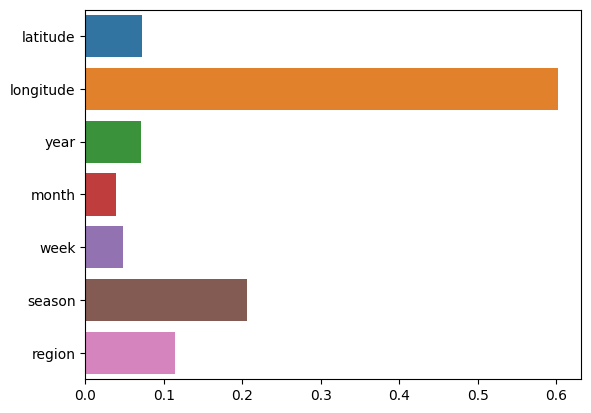

In [188]:
_, train_preds = cv_it(model=xgb, X_train=X_train, y_train=y_train, X_test=None, y_test=None, splits=10, cv_predict=True)
rmse(np.round(train_preds), y_train)

In [189]:
0.76 - 0.67

0.08999999999999997

In [190]:
0.690902590749336 + 0.09

0.780902590749336

In [191]:
# may be it's all coz of region

rmse(train_data.region.map(reg_sev_map), train_data.severity), rmse(X_train.region, y_train) #  --> nah...

(0.894754808017972, 0.8935478132935858)

In [238]:
reg_map = {
    'south' : 0,
    'northeast' : 1,
    'west' : 2,
    'midwest' : 3
}

In [239]:
X_train.region = tr_data.region.map(reg_map)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, predictor=None, random_state=12000,
             reg_alpha=None, reg_lambda=None, ...)
Using cols:  ['latitude' 'longitude' 'year' 'month' 'week' 'season' 'region']
-----------------------Fold-0-------------------------
Training on 13050 samples
Validating on 1451 samples
Train RMSE:  0.637103118138471
Val RMSE: 0.7102673223467764
-----------------------Fold-1--

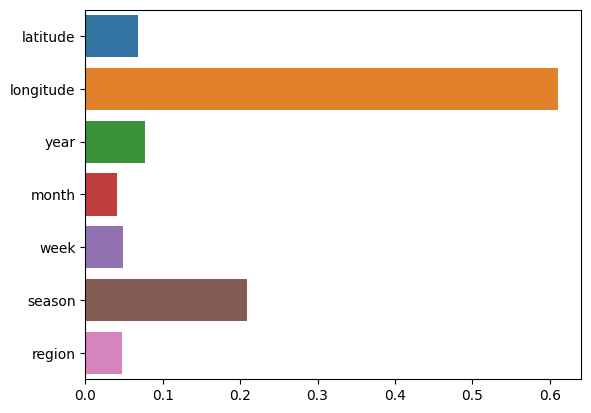

In [241]:
#  with region as int
xgb = XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
print(xgb)

cv_it(model=xgb, X_train=X_train, y_train=y_train, X_test=None, y_test=None, splits=10, cv_predict=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, predictor=None, random_state=12000,
             reg_alpha=None, reg_lambda=None, ...)
Using cols:  ['latitude' 'longitude' 'year' 'month' 'week' 'season']
-----------------------Fold-0-------------------------
Training on 13050 samples
Validating on 1451 samples
Train RMSE:  0.6386647949484248
Val RMSE: 0.7122052995432216
-----------------------Fold-1----------

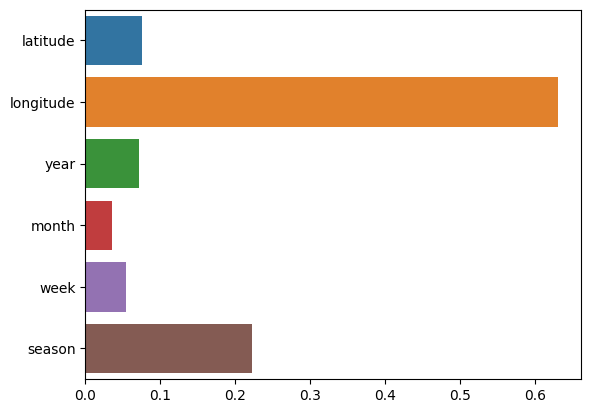

In [192]:
# without region    

xgb = XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
print(xgb)

cv_it(model=xgb, X_train=X_train.drop(columns='region'), y_train=y_train, X_test=None, y_test=None, splits=10, cv_predict=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, predictor=None, random_state=12000,
             reg_alpha=None, reg_lambda=None, ...)
Using cols:  ['year' 'month' 'week' 'season' 'region']
-----------------------Fold-0-------------------------
Training on 13050 samples
Validating on 1451 samples
Train RMSE:  0.825132057235322
Val RMSE: 0.8663237760254308
-----------------------Fold-1-------------------------

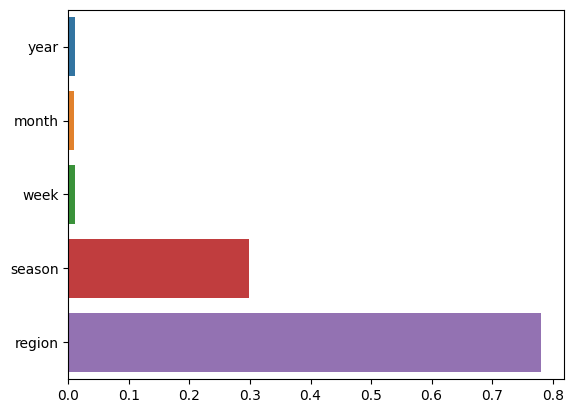

In [193]:
# without lat, long

xgb = XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
print(xgb)

cv_it(model=xgb, X_train=X_train.drop(columns=[ 'latitude', 'longitude']), y_train=y_train, X_test=None, y_test=None, splits=10, cv_predict=False)
#  so this is what happened last time!

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, predictor=None, random_state=12000,
             reg_alpha=None, reg_lambda=None, ...)
Using cols:  ['year' 'month' 'week' 'season']
-----------------------Fold-0-------------------------
Training on 13050 samples
Validating on 1451 samples
Train RMSE:  1.102557111404233
Val RMSE: 1.1050912813786862
-----------------------Fold-1-------------------------
Training

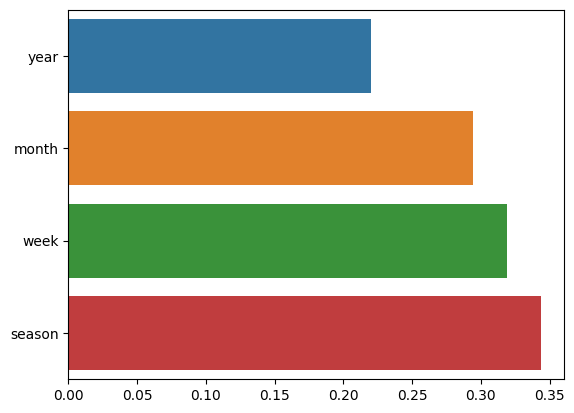

In [194]:
#  without lat and lng and reg

xgb = XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
print(xgb)

cv_it(model=xgb, X_train=X_train.drop(columns=['region', 'latitude', 'longitude']), y_train=y_train, X_test=None, y_test=None, splits=10, cv_predict=False)

In [ ]:
#  Believe in Stratified KFold??

Using cols:  ['latitude' 'longitude' 'year' 'month' 'week' 'season' 'region']
-----------------------Fold-0-------------------------
Training on 13050 samples
Validating on 1451 samples
Train RMSE:  0.637103118138471
Val RMSE: 0.7102673223467764
-----------------------Fold-1-------------------------
Training on 13051 samples
Validating on 1450 samples
Train RMSE:  0.64127439970723
Val RMSE: 0.6756861136192833
-----------------------Fold-2-------------------------
Training on 13051 samples
Validating on 1450 samples
Train RMSE:  0.6427662232458754
Val RMSE: 0.6812766919794649
-----------------------Fold-3-------------------------
Training on 13051 samples
Validating on 1450 samples
Train RMSE:  0.639659322398961
Val RMSE: 0.6977797300897597
-----------------------Fold-4-------------------------
Training on 13051 samples
Validating on 1450 samples
Train RMSE:  0.6419909076398975
Val RMSE: 0.6643638388299198
-----------------------Fold-5-------------------------
Training on 13051 samples


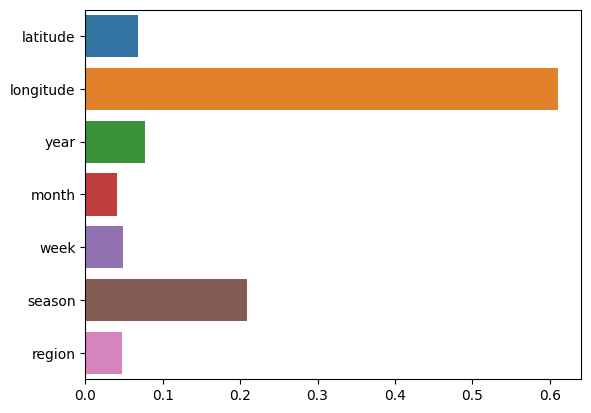

In [248]:
test_cv_preds, train_cv_preds = cv_it(model=xgb, X_train=X_train, y_train=y_train, X_test=X_train, y_test=None, splits=10, cv_predict=True)
# cross checking cv preds

In [252]:
rmse(np.clip(np.round(test_cv_preds.mean(axis=1)), 1, 5), y_train)

0.6394281460075301

In [253]:
rmse(np.clip(np.round(np.round(test_cv_preds).mean(axis=1)), 1, 5), y_train)

0.6412051614190357

In [301]:
y_train.value_counts(normalize=True)

1.0    0.439487
4.0    0.208261
2.0    0.189435
3.0    0.159575
5.0    0.003241
Name: severity, dtype: float64

In [332]:
analyize_matches(y_pred =np.round(test_cv_preds.mean(axis=1)), y_true=y_train)

Exact matches:  0.6607130542721191
Missed by 1:  0.3168746982966692
Missed by 2:  0.021929522101924004
Missed by 3:  0.00048272532928763534
Missed by 4:  0.0

Severity 1 : accuracy: 29.722088131852974% - prevalence: 43.94869319357286%
Severity 2 : accuracy: 12.70946831253017% - prevalence: 18.943521136473347%
Severity 3 : accuracy: 4.958278739397283% - prevalence: 15.957520171022688%
Severity 4 : accuracy: 18.681470243431487% - prevalence: 20.826149920695126%
Severity 5 : accuracy: 0.0% - prevalence: 0.32411557823598375%

Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.83      0.68      0.75      6373
         2.0       0.35      0.67      0.46      2747
         3.0       0.60      0.31      0.41      2314
         4.0       0.93      0.90      0.91      3020
         5.0       0.00      0.00      0.00        47

    accuracy                           0.66     14501
   macro avg   

# Test predictions

In [195]:
X_test = X_test[X_train.columns]
X_test

,latitude,longitude,year,month,week,season,region
1,36.559700,-121.510000,2016,8,35,3,4
12,33.042600,-117.076000,2014,11,44,4,4
14,40.703968,-80.293050,2015,8,35,3,2
15,38.972500,-94.672930,2019,8,35,3,2
16,34.279000,-118.905000,2018,1,2,1,4
...,...,...,...,...,...,...,...
23556,40.136410,-80.473740,2019,7,28,3,2
23560,36.875400,-121.561000,2019,9,38,4,4
23563,34.210000,-78.929389,2019,7,29,3,2
23565,36.708500,-121.749000,2014,12,49,1,4


In [196]:
assert X_test.columns.tolist() == X_train.columns.tolist()

In [197]:
X_val.isin(X_train).sum()

latitude     0
longitude    0
year         0
month        0
week         0
season       0
region       0
dtype: int64

In [198]:
all_X_train = pd.concat([X_train, X_val], axis=0)
all_y_train = pd.concat([y_train, y_val], axis=0)

assert all_X_train.shape[0] == all_y_train.shape[0]
assert all_X_train.columns.tolist() == X_test.columns.tolist()

all_X_train.shape, all_y_train.shape

((17060, 7), (17060,))

In [199]:
X_test.week = X_test.week.astype('int')
X_test.region = X_test.region.map(reg_sev_map)

Using cols:  ['latitude' 'longitude' 'year' 'month' 'week' 'season' 'region']
-----------------------Fold-0-------------------------
Training on 15354 samples
Validating on 1706 samples
Train RMSE:  0.6472353807849958
Val RMSE: 0.6687637980520433
-----------------------Fold-1-------------------------
Training on 15354 samples
Validating on 1706 samples
Train RMSE:  0.6474366042876919
Val RMSE: 0.7021153768040306
-----------------------Fold-2-------------------------
Training on 15354 samples
Validating on 1706 samples
Train RMSE:  0.6455224484637436
Val RMSE: 0.6890535840811314
-----------------------Fold-3-------------------------
Training on 15354 samples
Validating on 1706 samples
Train RMSE:  0.6445127146241812
Val RMSE: 0.6962468468487136
-----------------------Fold-4-------------------------
Training on 15354 samples
Validating on 1706 samples
Train RMSE:  0.6501470259866183
Val RMSE: 0.6709514512551437
-----------------------Fold-5-------------------------
Training on 15354 samp

(6510, 10)

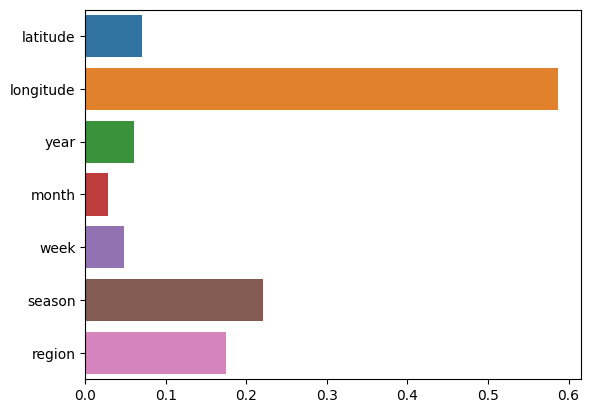

In [254]:
xgb = XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
test_preds, train_preds = cv_it(xgb, all_X_train, all_y_train, X_test=X_test, splits=10, cv_predict=True)
test_preds.shape

In [255]:

# trained only on X_train, y_train
# prev_preds_rmr = preds_rmr
# prev_preds_rm = preds_rm


In [337]:
preds_rmr = np.round(np.mean(np.round(test_preds), axis=1))
preds_rmr  # mean of rounded predictions

array([4., 3., 2., ..., 1., 4., 3.])

In [338]:
preds_rm = np.round(np.mean(test_preds, axis=1))
preds_rm # rounded mean s

array([4., 3., 2., ..., 1., 4., 3.])

In [340]:
analyize_matches(prev_preds_rmr, preds_rmr), rmse(prev_preds_rmr, preds_rmr)

Exact matches:  0.8800307219662058
Missed by 1:  0.11996927803379416
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 21.689708141321045% - prevalence: 24.592933947772657%
Severity 2 : accuracy: 28.402457757296467% - prevalence: 31.889400921658982%
Severity 3 : accuracy: 17.1889400921659% - prevalence: 20.844854070660524%
Severity 4 : accuracy: 20.368663594470046% - prevalence: 21.981566820276495%
Severity 5 : accuracy: 0.07680491551459294% - prevalence: 0.07680491551459294%

Classification report:
              precision    recall  f1-score   support

         0.0       0.67      0.45      0.54        40
         1.0       0.90      0.88      0.89      1601
         2.0       0.85      0.89      0.87      2076
         3.0       0.85      0.82      0.84      1357
         4.0       0.93      0.93      0.93      1431
         5.0       0.71      1.00      0.83         5

    accuracy                           0.88      6510
   macro avg       0.82      0.83

(None, 0.3463658153366093)

In [341]:
analyize_matches(prev_preds_rm, preds_rm), rmse(prev_preds_rm, preds_rm)

Exact matches:  0.8920122887864823
Missed by 1:  0.10798771121351766
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 22.887864823348693% - prevalence: 25.483870967741932%
Severity 2 : accuracy: 26.973886328725037% - prevalence: 30.52227342549923%
Severity 3 : accuracy: 19.3394777265745% - prevalence: 22.642089093701998%
Severity 4 : accuracy: 19.662058371735792% - prevalence: 20.75268817204301%
Severity 5 : accuracy: 0.07680491551459294% - prevalence: 0.07680491551459294%

Classification report:
              precision    recall  f1-score   support

         0.0       0.59      0.50      0.54        34
         1.0       0.92      0.90      0.91      1659
         2.0       0.87      0.88      0.88      1987
         3.0       0.88      0.85      0.86      1474
         4.0       0.92      0.95      0.93      1351
         5.0       0.50      1.00      0.67         5

    accuracy                           0.89      6510
   macro avg       0.78      0.85  

(None, 0.32861483717799117)

In [342]:
analyize_matches(preds_rmr, preds_rm)
# 265.0 samples are off!

Exact matches:  0.9552995391705069
Missed by 1:  0.04470046082949309
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 23.68663594470046% - prevalence: 24.10138248847926%
Severity 2 : accuracy: 30.53763440860215% - prevalence: 33.31797235023041%
Severity 3 : accuracy: 19.78494623655914% - prevalence: 20.18433179723502%
Severity 4 : accuracy: 21.044546850998465% - prevalence: 21.874039938556066%
Severity 5 : accuracy: 0.09216589861751152% - prevalence: 0.10752688172043011%

Classification report:
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89        27
         1.0       0.95      0.98      0.97      1569
         2.0       0.99      0.92      0.95      2169
         3.0       0.90      0.98      0.94      1314
         4.0       0.99      0.96      0.97      1424
         5.0       0.60      0.86      0.71         7

    accuracy                           0.96      6510
   macro avg       0.88      0.94    

In [343]:
0.044700460829493095 * len(test_preds)

291.00000000000006

In [344]:
pd.Series(np.clip(preds_rm, 1, 5)).value_counts(normalize=True)

2.0    0.309985
1.0    0.254224
3.0    0.220737
4.0    0.213518
5.0    0.001536
dtype: float64

In [345]:
pd.Series(np.clip(preds_rmr, 1, 5)).value_counts(normalize=True)

2.0    0.333180
1.0    0.245161
4.0    0.218740
3.0    0.201843
5.0    0.001075
dtype: float64

In [346]:
train_preds = np.round(train_preds)
pd.Series(np.clip(train_preds, 1, 5)).value_counts(normalize=True)

2.0    0.363306
1.0    0.350762
4.0    0.200879
3.0    0.084877
5.0    0.000176
dtype: float64

In [347]:
train_data.severity.value_counts(normalize=True)

1.0    0.439449
4.0    0.207913
2.0    0.189859
3.0    0.159379
5.0    0.003400
Name: severity, dtype: float64

In [348]:
# make submissions

sub_format.severity = preds_rmr.astype('int')
sub_format.to_csv('../submissions/to submit/xgb_1k_cv_preds_rmr.csv', index=False)

sub_format.severity = preds_rm.astype('int')
sub_format.to_csv('../submissions/to submit/xgb_1k_cv_preds_rm.csv', index=False)

In [349]:
rmse(preds_rmr, preds_rm)

0.2114248349402054

# Soo...
- skf is the way?
- Add more fts for nxt iter.
- xgb on latlngreg is @ 0.69 skf but got @ 0.8911 on lb 
- idk what's happening 
- Where could be the bug?